<br>
<br>

# To Default or not to Default
### Fred Park
<br>
<br>

My main objective here is to demonstrate how simple it can be to hit the ground running for asking interesting questions against the plethora of datasets available today.

* * *

In [8]:
# Let's begin with some imports...

import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.sparse import csr_matrix as sparse_matrix
    
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import TruncatedSVD

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures, Normalizer, scale, StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectFromModel

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

## Can we predict if one will default on their credit statements?



In the UCI default of credit card clients dataset, we find factors like age, education, and income that may be relevant for predicting one's potential for defaulting on their credit.
<br>
<br>
Let's start with some summary statistics:



In [9]:
data = pd.read_excel("ccd.xls")
X = data[1:len(data)]
n = len(X)

print("Proportion of defaults: " + str(X["Y"].sum()/n))
print("\nMean balance for non-defaults: " + str(X["X1"][X["Y"]==0].mean()))
print("Median balance for non-defaults: " + str(X["X1"][X["Y"]==0].median()))
print("\nMean balance for defaults: " + str(X["X1"][X["Y"]==1].mean()))
print("Median balance for defaults: " + str(X["X1"][X["Y"]==1].median()))

X_x = data.loc[:, :'X23'].iloc[1:].astype(float)
Y = data.loc[:,'Y'].iloc[1:].astype(float)
X_default = X_x[Y==1]
X_nondefault = X_x[Y==0]

avg_age = X_default.loc[:,'X5'].mean(axis=0)
print("\nAverage age of people with default payments:", avg_age)

avg_ed = X_default.loc[:,'X3'].median(axis=0)
print("Median education of people with default payments:", avg_ed)

Proportion of defaults: 0.2212

Mean balance for non-defaults: 178099.72607430234
Median balance for non-defaults: 150000.0

Mean balance for defaults: 130109.65641952984
Median balance for defaults: 90000.0

Average age of people with default payments: 35.72573839662447
Median education of people with default payments: 2.0


### Now let's examine some plots for default and non-default payments.

Let's plot some boxes for visualizing average bill amounts for default and non-default payments as a first attempt at gauging spending habits.

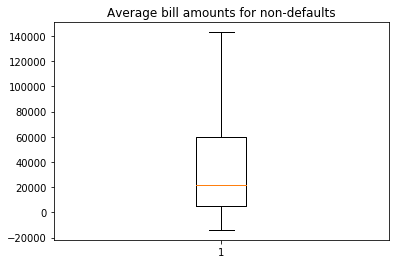

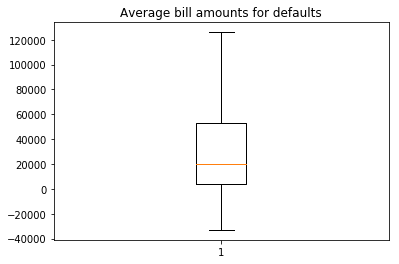

In [10]:
meansX =  X_nondefault.loc[:,'X12':'X16'].mean(axis=1);
plt.title("Average bill amounts for non-defaults");
plt.boxplot(meansX, 0, '');
plt.figure();
plt.title("Average bill amounts for defaults");
plt.boxplot(X_default.loc[:,'X12':'X16'].mean(axis=1), 0, '');

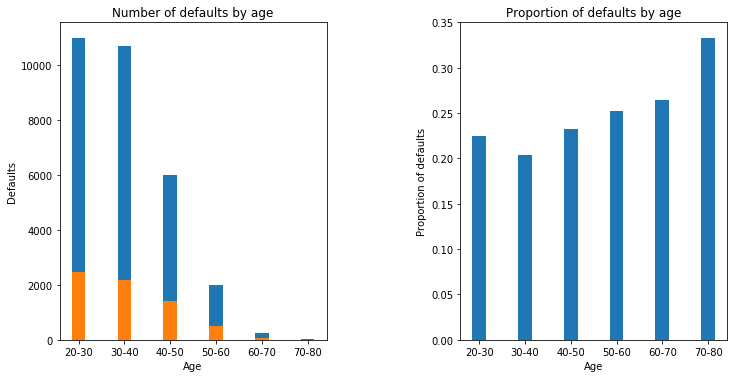

In [11]:
# ======================
# Visualizing age
# =====================

f, axs = plt.subplots(1,2,figsize=(10,5))
f.tight_layout()
plt.subplots_adjust(wspace = 0.5, hspace = 0.5)

# Let's split up the age in decades
ages = pd.cut(X['X5'], bins=np.linspace(20,80,7))
ages_category = pd.get_dummies(ages)
ages_table = pd.concat([X['Y'], ages_category],axis=1)

by_age = [ages_category.sum()[x] for x in np.arange(6)]
defaults_by_age = [ages_table[ages_table["Y"]==1].sum()[x] for x in np.arange(1,7)]
prop_age = np.divide(defaults_by_age,by_age)

axs[0].bar(["20-30","30-40","40-50","50-60","60-70","70-80"], by_age, 0.3)
axs[0].bar(["20-30","30-40","40-50","50-60","60-70","70-80"], defaults_by_age, 0.3)
axs[0].set_title('Number of defaults by age')
axs[0].set_xlabel('Age')
axs[0].set_ylabel('Defaults')

axs[1].bar(["20-30","30-40","40-50","50-60","60-70","70-80"], prop_age, 0.3)
axs[1].set_title('Proportion of defaults by age')
axs[1].set_xlabel('Age')
axs[1].set_ylabel('Proportion of defaults');



There seems to be an upward trend in the data with defaults as one gets older, with the exception of those aged 20-29 - perhaps indulging in their transition to adulthood?



#### Legend

- Gender (1 = male; 2 = female). 
- Education (1 = graduate school; 2 = university; 3 = high school; 4 = others). 
- Marital status (1 = married; 2 = single; 3 = others). 

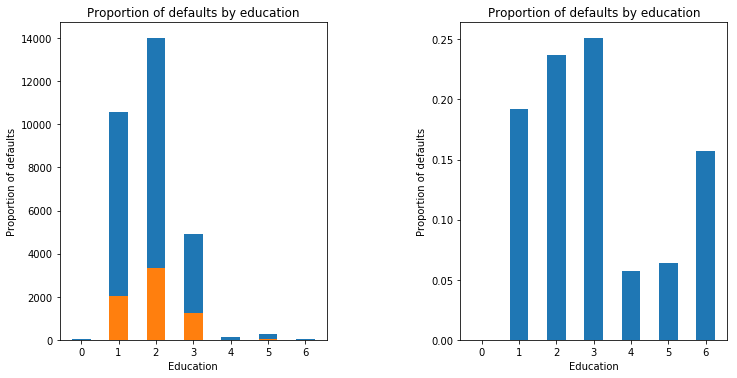

In [12]:
# ======================
# Visualizing education
# ======================

f, axs = plt.subplots(1,2,figsize=(10,5))
f.tight_layout()
plt.subplots_adjust(wspace = 0.5, hspace = 0.5)

ed = list(X["X3"].value_counts(sort=False))
defaults_by_ed = list(X["X3"][X["Y"]==1].value_counts(sort=False))
defaults_by_ed.insert(0,0)
prop_ed = np.divide(defaults_by_ed,ed)

axs[0].bar(np.arange(7),ed,width=0.5)
axs[0].bar(np.arange(7),defaults_by_ed,width=0.5)
axs[0].set_title('Proportion of defaults by education')
axs[0].set_xlabel('Education')
axs[0].set_ylabel('Proportion of defaults')

axs[1].bar(np.arange(7),prop_ed,width=0.5)
axs[1].set_title('Proportion of defaults by education')
axs[1].set_xlabel('Education')
axs[1].set_ylabel('Proportion of defaults');



It seems that with higher levels of education, the proportion of defaults
slowly decrease.



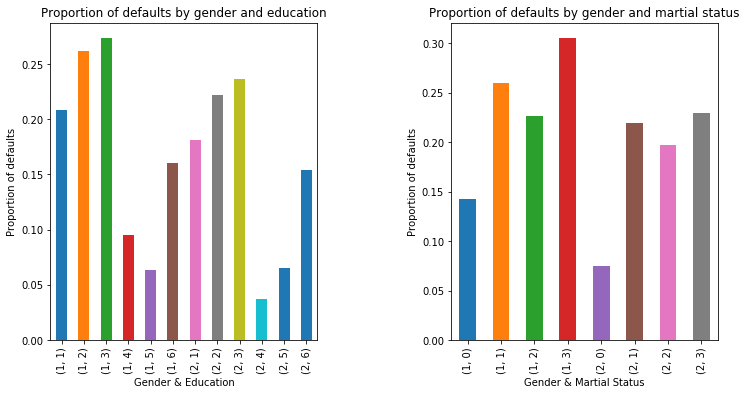

In [13]:
# ======================
# Proportion of defaults for gender & education
# ======================

f, axs = plt.subplots(1,2,figsize=(10,5))
f.tight_layout()
plt.subplots_adjust(wspace = 0.5, hspace = 0.5)

education_martial_defaults = X[["X2","X3"]][X["Y"]==1].groupby(["X2","X3"]).size()
education_martial = X[["X2","X3"]].groupby(["X2","X3"]).size()
education_martial_prop =education_martial_defaults/education_martial
education_martial_prop[~education_martial_prop.isnull()].plot(kind="bar", ax=axs[0])
axs[0].set_title('Proportion of defaults by gender and education')
axs[0].set_xlabel('Gender & Education')
axs[0].set_ylabel('Proportion of defaults');


# ======================
# Proportion of defaults for gender & martial status
# ======================

education_martial_defaults = X[["X2","X4"]][X["Y"]==1].groupby(["X2","X4"]).size()
education_martial = X[["X2","X4"]].groupby(["X2","X4"]).size()
education_martial_prop =education_martial_defaults/education_martial
education_martial_prop[~education_martial_prop.isnull()].plot(kind="bar", ax=axs[1])
axs[1].set_title('Proportion of defaults by gender and martial status')
axs[1].set_xlabel('Gender & Martial Status')
axs[1].set_ylabel('Proportion of defaults');



Plotting gender with education gives us an expected downward trend of lowering default rates as one gets more school. However, a higher proportion of men seem to default than women.


And among the 4 combinations of Male/Woman and Single/Married:
- Married men have the highest proportion of defaults
- Single women have the lowest proportion of defaults



* * *

## Predictions


Now for some ***predictions*** - first, we'll read in the data and chop it up into train/validation/test sets. Validation error is a popular metric for seeing how well we do with our models - here, it approximately measures how well the model does in predicting if someone will default or not.



In [14]:
X = pd.read_excel("ccd.xls")
X = X[1:len(X)] # remove column labels

n = len(X)
n_col = len(X.columns)
x = X.iloc[0:n,0:n_col-1]
y = X["Y"][0:n]

# divide into train/test
X_train, X_test, y_train, y_test = train_test_split( x, y, test_size=0.2, random_state=27)

# divide train into train/valid
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=27)

# matrixify
X_train = X_train.astype(float).as_matrix()
y_train = y_train.astype(float).as_matrix()
X_valid = X_valid.astype(float).as_matrix()
y_valid = y_valid.astype(float).as_matrix()
X_test = X_test.astype(float).as_matrix()
y_test = y_test.astype(float).as_matrix()

c:\users\fredp\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()
c:\users\fredp\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
c:\users\fredp\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
c:\users\fredp\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:19: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
c:\users\fredp\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
c:\users\fre

### Logistic Regression with L2-Regularization



Let's begin using logistic regression with L2-regularization and see how well it does with varying regularization strengths (strong to weak).



In [15]:
# =============== Logistic Regression ========================

from sklearn.linear_model import LogisticRegression

best_c = 0
best_err_so_far = 1
C = [0.000001, 0.001, 0.1, 0.5, 1, 1.5, 2, 5, 20, 100]
v_errors = np.zeros(len(C))
for i, j in enumerate(C):
    model = LogisticRegression(penalty='l2', solver='lbfgs', C=j)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    te_error = 1-accuracy_score(y_valid.ravel(),y_pred)
    v_errors[i] = te_error
    if te_error < best_err_so_far:
        best_c = j
        best_err_so_far = te_error

print("Best C: " + str(best_c))
print("Validation error: %.3f" % best_err_so_far)


# Best results: 
# =================================
# Best C: 0.5
# Validation error: 0.218

Best C: 0.5
Validation error: 0.218


### Logistic Regression with L1-Regularization

In [16]:
# =============== Logistic Regression ========================

from sklearn.linear_model import LogisticRegression

best_c = 0
best_err_so_far = 1
C = [0.000001, 0.001, 0.1, 0.5, 1, 1.5, 2, 5, 20, 100]
v_errors = np.zeros(len(C))
for i, j in enumerate(C):
    model = LogisticRegression(penalty='l1', C=j)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    te_error = 1-accuracy_score(y_valid.ravel(),y_pred)
    v_errors[i] = te_error
    if te_error < best_err_so_far:
        best_c = j
        best_err_so_far = te_error

print("Best C: " + str(best_c))
print("Validation error: %.3f" % best_err_so_far)


# Best results: 
# =================================
# Best C: 100
# Validation error: 0.186

Best C: 100
Validation error: 0.186


### K-Nearest Neighbors



Next we look at how well KNN performs - because there are so many examples, we can search for larger values of k to avoid overfitting. We optimize for this number of neighbors and the different metrics of KNN to measure which is the best way to score distance between points, using k-fold cross validation.



In [ ]:
# =============== KNN ========================

from sklearn.neighbors import KNeighborsClassifier

n = len(X_train)

best_so_far = 1
best_i = 0
best_metric = ""
metrics = ["euclidean","manhattan","chebyshev","minkowski","hamming","canberra","braycurtis"]
for j in metrics:
    inner_so_far = 1
    inner_best_i = 0
    for i in np.arange(50,100):
        for z in range(10):
            begin = int(z * n / 10)
            end = int((z + 1) * n / 10)

            Xvalid = X_train[begin:end]
            yvalid = y_train[begin:end]
            
            Xtrain = np.append(X_train[:begin,:], X_train[end:,:], axis=0)
            ytrain = np.append(y_train[:begin], y_train[end:], axis=0)
            model = KNeighborsClassifier(i, metric=j)
            
            model.fit(Xtrain, ytrain)
            y_pred = model.predict(Xvalid)
            v_error = np.mean(y_pred != yvalid)
            if (v_error < inner_so_far):
                inner_best_i = i
                inner_so_far = v_error
    if (inner_so_far < best_so_far):
        best_so_far = inner_so_far
        best_i = inner_best_i
        best_metric = j
    print("Metric: " + j)
    print("Best K: " + str(inner_best_i))
    print("Validation error: %.3f" % inner_so_far)

print("Metric: " + best_metric)
print("Best K: " + str(best_i))
print("Validation error: %.3f" % best_so_far)


# Best results:
# ==================
# Metric: hamming
# Best K: 59
# Validation error: 0.181



# =========================
# Test on validation set
# =========================
model = KNeighborsClassifier(59, metric="hamming")
model.fit(X_train, y_train)            
y_pred = model.predict(X_valid)
te_error = np.mean(y_pred != y_valid)
print("Validation error: " + str(te_error))

# Validation error: 0.18895833333333334

Metric: euclidean
Best K: 96
Validation error: 0.208
Metric: manhattan
Best K: 98
Validation error: 0.206
Metric: chebyshev
Best K: 92
Validation error: 0.207
Metric: minkowski
Best K: 96
Validation error: 0.208


### Neural Net



We now examine using a neural network, scikit's MLPClassifier, to predict defaults. We optimize for multiple combinations of hidden layer sizes, as well as varying alpha and taking the mode of the best set of these hyperparameters. Instead of using cross validation, we take the mode of the best set of hyperparameters based on a range of different initializations. We could have used scikit's grid-search feature, but let's write it manually for fun!

*Note, this will take a while!



In [ ]:
# =============== Neural Net ========================

from sklearn.neural_network import MLPClassifier

best_layer_size_res = []
best_alpha_res = []


inner_best_layer_size = 0
inner_best_alpha = 0
inner_best_error = 1

hidden_layers = [(100, 100, 10), (300,100,10), (200,100,100,100), (100,100,10,10,10),
                (100,10,10), (100,100,10,10), (50,20,20,10)]
alpha = [0.000001,  0.00001, 0.0005, 0.0001, 0.001,  0.01, 0.1, 1]
seeds = [1, 2, 3, 5, 8, 13, 21, 34, 55]

for s in seeds:
	inner_best_layer_size = 0
	inner_best_alpha = 0
	inner_best_error = 1
	for i in hidden_layers:
		error_so_far = 1
		inner_alpha = 1
		for j in alpha:
			model = MLPClassifier(hidden_layer_sizes=i, random_state=s, alpha=j)
			model.fit(X_train, y_train)
			y_pred = model.predict(X_valid)
			te_error = np.mean(y_pred != y_valid)
			if te_error < error_so_far:
				error_so_far = te_error
				inner_alpha = j
		if error_so_far < inner_best_error:
			inner_best_layer_size = i
			inner_best_alpha = inner_alpha
			inner_best_error = error_so_far
	best_layer_size_res.append(inner_best_layer_size)
	best_alpha_res.append(inner_best_alpha)
	print("Seed: " + str(s))
	print("Best layer size: " + str(inner_best_layer_size))
	print("Best alpha: " + str(inner_best_alpha))
	print("Best test error: %.3f" % inner_best_error)
	print("=========================")

hidden_layer_size_mode = max(set(best_layer_size_res), key=best_layer_size_res.count)
print("Best hidden layer size (mode): " + str(hidden_layer_size_mode))
print("Using alpha: " + str(best_alpha_res[best_layer_size_res.index(hidden_layer_size_mode)]))


# =========================
# Best hidden layer size (mode): (100, 100, 10, 10, 10)
# Alpha: 1e-06
# Validation error = 0.217

### Decision Tree



Now we examine decision trees. Optimizing over different minimum number of samples required to split as well as the depth of the tree, we take advantage of k-fold cross validation to better gauge our model.

*Note, this will take a while!



In [ ]:
# =============== Decision Tree ========================

from sklearn.tree import DecisionTreeClassifier

n = len(X_train)

best_depth = 1
best_split = 2
best_error = 1
depths = np.arange(1,30)

for j in [2, 30, 300, 500, 750, 1000, 3000]:
    for i, max_depth in enumerate(depths):
        for z in range(10):
            begin = int(z * n / 10)
            end = int((z + 1) * n / 10)

            Xvalid = X_train[begin:end]
            yvalid = y_train[begin:end]
            
            Xtrain = np.append(X_train[:begin,:], X_train[end:,:], axis=0)
            ytrain = np.append(y_train[:begin], y_train[end:], axis=0)

            model = DecisionTreeClassifier(max_depth=max_depth, min_samples_split=j, criterion='entropy', random_state=27)
            model.fit(Xtrain, ytrain)
            y_pred = model.predict(Xvalid)
            te_error = np.mean(y_pred != yvalid)
            if te_error < best_error:
                best_error = te_error
                best_split = j
                best_depth = max_depth

print("=================================")
print("Results: ")
print("Validation error: %.3f" % te_error)
print("Depth: " + str(best_depth))
print("Best num to split: " + str(best_split))

# =========================
# Results:
# Validation error: 0.178
# Depth: 9
# Best num to split: 300


# =========================
# Test on validation set
# =========================
model = DecisionTreeClassifier(max_depth=9, min_samples_split=300, criterion='entropy', random_state=27)
model.fit(X_train, y_train)            
y_pred = model.predict(X_valid)
te_error = np.mean(y_pred != y_valid)
print("Validation error: " + str(te_error))

# Validation error: 0.18333333333333332

### Some more model exploration...

In [ ]:
# Neural Nets Logistic 
nnModel = MLPClassifier(activation='logistic').fit(X_train, y_train)
y_hat = nnModel.predict(X_train)
print("\nLogistic neural net validation error:", 1-accuracy_score(y_train.ravel(),y_hat))

# Neural Nets Relu
nnModelr = MLPClassifier().fit(X_train, y_train)
y_hat = nnModelr.predict(X_train)
print("\nRelu neural net validation error:", 1-accuracy_score(y_train.ravel(),y_hat))

# Random Forest
rfModel = RandomForestClassifier().fit(X_train, y_train)
y_hat = rfModel.predict(X_train)
print("\nRandom forest validation error:", 1-accuracy_score(y_train.ravel(),y_hat))
print("* Best so far!")

# Linear SVC
svcModel = LinearSVC().fit(X_train, y_train)
y_hat = svcModel.predict(X_train)
print("\nLinear SVC validation error:", 1 - accuracy_score(y_train.ravel(),y_hat))



## Feature Exploration

Next we will explore some feature transformations and selections - dabbling in change of basis, normalizing, and scaling of the data.



In [ ]:
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X_train)

# Logistic Regression with L2 Regularization
print("\nPolynomial Logistic L2 classifier validation error with c = 0.1, deg=2")
l2Model = LogisticRegression(penalty='l2', solver='lbfgs', C=0.1).fit(X_poly, y_train)
y_hat = l2Model.predict(X_poly)
print(1-accuracy_score(y_train.ravel(),y_hat))

# # Logistic Regression with L1 Regularization
# print("Polynomial Logistic L1 classifier validation error with c = 0.1, deg=2")
# l1Model = LogisticRegression(penalty='l1', C=0.1).fit(X_poly, y_train)
# y_hat = l1Model.predict(X_poly)
# print(1-accuracy_score(y_train.ravel(),y_hat))

poly = PolynomialFeatures(degree=3)
X_poly = poly.fit_transform(X_train)

# Logistic Regression with L2 Regularization
print("\nPolynomial Logistic L2 classifier validation error with c = 0.1, deg=3")
l2Model = LogisticRegression(penalty='l2', solver='lbfgs', C=0.1).fit(X_poly, y_train)
y_hat = l2Model.predict(X_poly)
print(1-accuracy_score(y_train.ravel(),y_hat))

# # Logistic Regression with L1 Regularization
# print("Polynomial Logistic L1 classifier validation error with c = 0.1, deg=3")
# l1Model = LogisticRegression(penalty='l1', C=0.1).fit(X_poly, y_train)
# y_hat = l1Model.predict(X_poly)
# print(1-accuracy_score(y_train.ravel(),y_hat))

In [ ]:
# Normalizing Data
normalizer = Normalizer().fit(X)
X_normal = normalizer.transform(X_train)

# Logistic Regression with L2 Regularization
print("\nNormalized Logistic L2 classifier validation error with c = 0.1")
l2Model = LogisticRegression(penalty='l2', solver='lbfgs', C=0.1).fit(X_normal, y_train)
y_hat = l2Model.predict(X_normal)
print(1-accuracy_score(y_train.ravel(),y_hat))

# Logistic Regression with L1 Regularization
print("Normalized Logistic L1 classifier validation error with	 c = 0.1")
l1Model = LogisticRegression(penalty='l1', C=0.1).fit(X_normal, y_train)
y_hat = l1Model.predict(X_normal)
print(1-accuracy_score(y_train.ravel(),y_hat))

In [ ]:
# Standard Scaler
scaler = StandardScaler()
X_scaler = scaler.fit_transform(X_train)

# Logistic Regression with L2 Regularization
print("\nStandard Scaler Logistic L2 classifier validation error with c = 0.1")
l2Model = LogisticRegression(penalty='l2', solver='lbfgs', C=0.1).fit(X_scaler, y_train)
y_hat = l2Model.predict(X_scaler)
print(1-accuracy_score(y_train.ravel(),y_hat))

# Logistic Regression with L1 Regularization
print("\nStandard Scaler Logistic L1 classifier validation error with c = 0.1")
l1Model = LogisticRegression(penalty='l1', C=0.1).fit(X_scaler, y_train)
y_hat = l1Model.predict(X_scaler)
print(1-accuracy_score(y_train.ravel(),y_hat))

print("\nStandard Scaler KNN validation error with k = 0.59, using hamming distance")
model = KNeighborsClassifier(59, metric="hamming")
model.fit(X_scaler, y_train)
y_pred = model.predict(X_valid)
te_error = np.mean(y_pred != y_valid)
print("Validation error: " + str(te_error))

## Feature addition and selection

We add two new features:
1. Payment rate: computed by Monthly Bill statement / Amount paid that month
    - This could be insightful as higher proportions of bill payments can indicate they are on a good track
2. Number of paid months
    - More consistent payments with each statement might indicate that the person has a stable income, and thus avoid defaulting
    
Additionally, we use one-hot encoding to binarize our categorial features (age, education, gender, marital status).

In [ ]:
from sklearn.model_selection import train_test_split

X = pd.read_excel("../data/ccd.xls")
X = X[1:len(X)] # remove column labels


# New feature: payment rate (Monthly Bill statement / Amount paid that month)
np.seterr(divide='ignore', invalid='ignore')
bill_amt = X.iloc[:,11:17].astype('float64').as_matrix()
pay_amt = X.iloc[:,17:23].astype('float64').as_matrix()
prop_paid = pay_amt/bill_amt
pay_rate = [prop_paid[i].sum()/np.count_nonzero(prop_paid[i]) for i in np.arange(len(prop_paid))]
pay_rate = pd.DataFrame(np.nan_to_num(pay_rate))
# ceiling for outliers
pay_rate[pay_rate >= 10] = 10
pay_rate[pay_rate <= -10] = -10
X.insert(23, "X24", pay_rate)
X.iat[29999,23] = 0 # remove NaN

# New feature: # of paid months
non_zeros = [np.count_nonzero(i) for i in pay_amt]
nz = pd.DataFrame(np.nan_to_num(non_zeros))[0]
X.insert(24, "X25", nz)
X.iat[29999,24] = 0 # remove NaN

n = len(X)
n_col = len(X.columns)
x = X.iloc[0:n,0:n_col-1]

# Split gender into columns
gender = pd.cut(X['X2'], bins=[0,1,2])
gender_cols = pd.get_dummies(gender)
x.drop(['X2'], axis=1, inplace=True)
x = pd.concat([x, gender_cols],axis=1)

# Split education into columns
educ = pd.cut(X['X3'], bins=[0,1,2,3,4,5,6])
educ_cols = pd.get_dummies(educ)
x.drop(['X3'], axis=1, inplace=True)
x = pd.concat([x, educ_cols],axis=1)

# Split martial status into columns
martial = pd.cut(X['X4'], bins=[0,1,2,3])
martial_cols = pd.get_dummies(martial)
x.drop(['X4'], axis=1, inplace=True)
x = pd.concat([x, martial_cols],axis=1)

# Split age into columns
ages = pd.cut(X['X5'], bins=np.linspace(20,80,7))
ages_cat = pd.get_dummies(ages)
x.drop(['X5'], axis=1, inplace=True)
x = pd.concat([x, ages_cat],axis=1)

y = X["Y"][0:n]
# divide into train/test
X_train, X_test, y_train, y_test = train_test_split( x, y, test_size=0.2, random_state=27)
# divide train into train/valid
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=27)

# matrixify
X_train = X_train.astype(float).as_matrix()
y_train = y_train.astype(float).as_matrix()
X_valid = X_valid.astype(float).as_matrix()
y_valid = y_valid.astype(float).as_matrix()
X_test = X_test.astype(float).as_matrix()
y_test = y_test.astype(float).as_matrix()



#### Using decision trees below on our new transformed dataset, we get a better validation error than before.



In [ ]:
from sklearn.tree import DecisionTreeClassifier

n = len(X_train)
print("starting..")

best_depth = 1
best_split = 2
best_error = 1
depths = np.arange(1,30)

for j in [2, 30, 300, 500, 750, 1000, 3000]:
    for i, max_depth in enumerate(depths):
        for z in range(10):
            begin = int(z * n / 10)
            end = int((z + 1) * n / 10)

            Xvalid = X_train[begin:end]
            yvalid = y_train[begin:end]
            
            Xtrain = np.append(X_train[:begin,:], X_train[end:,:], axis=0)
            ytrain = np.append(y_train[:begin], y_train[end:], axis=0)

            model = DecisionTreeClassifier(max_depth=max_depth, min_samples_split=j, criterion='entropy', random_state=27)
            model.fit(Xtrain, ytrain)
            y_pred = model.predict(Xvalid)
            te_error = np.mean(y_pred != yvalid)
            if te_error < best_error:
                best_error = te_error
                best_split = j
                best_depth = max_depth
print("=================================")
print("Results: ")
print("Validation error: %.3f" % te_error)
print("Depth: " + str(best_depth))
print("Best num to split: " + str(best_split))


# =================================
# Results: 
# Validation error: 0.178
# Depth: 7
# Best num to split: 300


# =========================
# Test on validation set
# =========================
model = DecisionTreeClassifier(max_depth=7, min_samples_split=300, criterion='entropy', random_state=27)
model.fit(X_train, y_train)            
y_pred = model.predict(X_valid)
te_error = np.mean(y_pred != y_valid)
print("Validation test error: " + str(te_error))

# Improvement!

# Validation test error: 0.18145833333333333

### The tallest tree of all

The above demonstrates that decision trees do better on our new transformed dataset. Thus, we will optimize a random forest and perform feature selection to gain confidence in our new features.

 

In [ ]:
# Random Forest Optimization - #6 depth, 10 features - 0.140, 100 estimates
parameters = {'max_features':[1,6,15,23], 'max_depth':[1,10,50,100,140,200],'n_estimators':[40,50,100,200,300]}
rfModel = RandomForestClassifier()
gridsearch = GridSearchCV(rfModel, parameters)
gridsearch.fit(X_train, y_train)
y_hat = gridsearch.predict(X_valid)
print("\nOptimized Random forest validation error:", 1-accuracy_score(y_valid.ravel(),y_hat))
print("Parameters:", gridsearch.best_params_ )

# Random Forest Feature Selection 
# Relevant Features In Order of Relevance: 6,5,1,12,23,15,13,14,17,16
extras = ExtraTreesClassifier().fit(X_train, y_train)
model = SelectFromModel(extras, prefit=True)
X_train_new = model.transform(X_train)
std = np.std([extras.feature_importances_ for tree in extras.estimators_], axis=0)
indices = np.argsort(extras.feature_importances_)[::-1]
# Print the feature ranking
print("Feature ranking:")
for f in range(X_train_new.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], extras.feature_importances_[indices[f]]))



The optimal set of parameters for our random forest is depth 7 with 23 features. We can also confirm that our new features are also selected for in our selection analysis.





## Predicting on the test set

Finally, running our best model (random forest) with our discovered hyperparameters on the test set...



In [ ]:
# Best model =Random Forest
rfModel = RandomForestClassifier(max_depth=7, n_estimators=100, max_features=23, random_state=27).fit(X_train, y_train)
y_pred = rfModel.predict(X_valid)
print("\nRandom forest validation error:", 1-accuracy_score(y_valid.ravel(), y_pred))

X = np.concatenate((X_train, X_valid))
y = np.concatenate((y_train, y_valid))

# Best model =Random Forest
rfModel = RandomForestClassifier(max_depth=7, n_estimators=100, max_features=23, random_state=27).fit(X, y)
y_pred = rfModel.predict(X_test)
print("\nRandom forest test error:", 1-accuracy_score(y_test.ravel(), y_pred))

# Conclusion

From what we've done so far, we see that the variance across all the different models is rather dense. This can be both encouraging and discouraging depending on how you look at the problem - nonetheless, I hope this was a good taster into the world of machine learning! 

If you have any questions, feel free to email me at fred.park9841@hotmail.com!